In [21]:
%run _common.ipynb
%matplotlib inline

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralconstitutive.constitutive import PowerLaw, StandardLinearSolid, ModifiedPowerLaw, KohlrauschWilliamsWatts, Hertzian
from neuralconstitutive.tipgeometry import Spherical
from neuralconstitutive.indentation import ConstantVelocityIndentation
from neuralconstitutive.ting import (
    force_approach,
    t1_ting,
    force_retract,
    force_approach_analytic,
    force_retract_analytic,
)
from neuralconstitutive.custom_types import FloatScalarLike

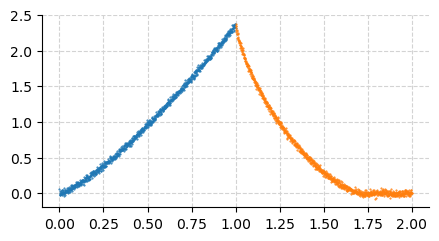

In [22]:
def simulate_data(constit, indent, tip, dt, noise_strength, seed=0):
    t_m = indent.t_m
    t_app = jnp.arange(0.0, t_m + dt, dt)
    t_ret = jnp.arange(t_m, 2 * t_m + dt, dt)

    f_app = force_approach_analytic(t_app, constit, indent, tip)
    f_ret = force_retract_analytic(t_ret, constit, indent, tip)
    f_max = f_ret[0]

    rng_key = jax.random.PRNGKey(seed)
    key_app, key_ret = jax.random.split(rng_key)
    noise_app = jax.random.normal(key_app, f_app.shape) * f_max * noise_strength
    noise_ret = jax.random.normal(key_ret, f_ret.shape) * f_max * noise_strength
    return t_app, t_ret, f_app + noise_app, f_ret + noise_ret


constit = PowerLaw(E0=1.0, alpha=0.2)
indent = ConstantVelocityIndentation(v=1.0)
tip = Spherical(R=1.0)

t_app, t_ret, f_app, f_ret = simulate_data(
    constit, indent, tip, dt=1e-3, noise_strength=0.01
)

fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
ax.plot(t_app, f_app, ".")
ax.plot(t_ret, f_ret, ".")

In [34]:
import optimistix as optx
import oryx
import equinox as eqx


def residual_app(constit, _):
    return f_app - force_approach(t_app, constit, indent, tip)


def residual_total(constit, _):
    res_app = residual_app(constit)
    res_ret = f_ret - force_retract(t_ret, constit, indent, tip)
    return jnp.concatenate((res_app, res_ret), axis=0)


@eqx.filter_jit
def curve_fit(
    objective_fn,
    y0,
    args,
    transform_fn,
    solver=optx.LevenbergMarquardt(rtol=1e-6, atol=1e-6),
):
    y0_unconstrained = oryx.core.inverse(transform_fn)(y0)

    def _fn(y_unconstrained, _):
        y_ = transform_fn(y_unconstrained)
        return objective_fn(y_, args)

    result = optx.least_squares(_fn, solver, y0_unconstrained)
    return eqx.tree_at(lambda res: res.value, result, transform_fn(result.value))

from scipy.stats import qmc
import numpy as np

def sample_latinhypercube(n_samples: int, *bounds: tuple[FloatScalarLike, FloatScalarLike], seed=0):
    bounds = np.stack(bounds, axis = -1)
    sampler = qmc.LatinHypercube(d=bounds.shape[-1], seed = seed)
    samples = sampler.random(n_samples)
    samples = qmc.scale(samples, bounds[0], bounds[1])
    return jnp.asarray(samples)



In [35]:
def transform_sls(sls: StandardLinearSolid):
    return jax.tree.map(lambda x: 10**x, sls)

def transform_pl(pl: PowerLaw):
    return PowerLaw(E0=10**pl.E0, alpha = jax.nn.sigmoid(pl.alpha))

def transform_mpl(mpl: ModifiedPowerLaw):
    return ModifiedPowerLaw(E0=10**mpl.E0, alpha = jax.nn.sigmoid(mpl.alpha))

def sample_sls(n_samples, seed = 10):
    samples = sample_latinhypercube(n_samples, (-2, 2), (-2, 2), (-4, 1), seed = seed)
    samples = 10**samples
    return eqx.filter_vmap(StandardLinearSolid)(*samples.T)

sls_initvals = sample_sls(100)
sls_initvals

## Might need to write a batched loop with tqdm support myself...


StandardLinearSolid(E1=f64[100], E_inf=f64[100], tau=f64[100])

In [36]:
res = eqx.filter_vmap(curve_fit, in_axes = (None, 0, None, None))(residual_app, sls_initvals, None, transform_sls)

In [37]:
res.value.E1

Array([ 1.12687861,  1.12687896,  1.12687902,  1.12687852,  1.12687902,
        1.12687898,  1.12682846,  1.12687899,  1.12687898,  1.12687852,
        1.12687776, 48.47679153,  1.12687901,  1.12682951,  1.12687908,
        1.12687784,  1.12687834,  1.12687896,  1.12687906,  1.1268285 ,
        1.12687897,  1.12682929,  1.12687896, 82.67469963,  1.12687897,
        1.12687859,  1.12682796,  1.12687908,  1.12687735,  1.12687847,
        1.12682947,  1.12682747,  1.1268774 ,  1.12682901,  1.12687897,
        1.12687896,  1.12687906,  1.12687904,  1.12687907,  1.12687899,
        1.12687898,  1.12687767,  1.12687896,  1.12682982,  1.12687897,
        1.12687861,  1.12687856,  1.12682961,  1.12687906,  1.12682923,
        1.12687897,  1.1268275 ,  1.12687896,  1.12687847,  1.12687897,
        1.12687855,  1.12682852,  1.12687773,  1.12687898,  1.12687903,
        1.12687858,  1.12687902, 84.86044734,  1.12682971,  1.12682787,
        1.12687896,  1.12687852,  1.12682843,  1.12687907,  1.12